In [1]:
# Post-processing with conformal prediction, using the logits tracked from training
import os
import numpy as np
import pandas as pd
import glob
import re
from scipy.special import softmax

from scipy.io import loadmat
from skimage.transform import resize
from sklearn.metrics import f1_score, confusion_matrix
import matplotlib.pyplot as plt

In [2]:
# analyze the dataframes for training and validation from each epoch
# we start by grabbing the dataframes

#csv_folder = "../logs/Baseline_r2plus1d_all/csvs/"
csv_folder = "../logs/R18_tmed/round1/csvs"
train_csvs = glob.glob(f"{csv_folder}/train_*.csv")
val_csvs = glob.glob(f"{csv_folder}/val_*.csv")

N_CLASSES=3
ALPHA=0.90

def extract_file_index(filename):
    # Use regular expression to find numerical part in the filename
    match = re.findall(r'\d+', filename)[-3]
    if match:
        numerical_part = int(match)
        return numerical_part
    else:
        # Return a default value or handle the case where no numerical part is found
        return None

# sort ascending by the numerical suffix for each file with regex search
def sort_by_epoch(files_list):
    indices = []
    for i in range(len(files_list)):
        index = extract_file_index(files_list[i])
        indices.append(index)
    new_array = [None] * len(indices)
    for j in range(len(indices)):
        new_array[indices[j]] = files_list[j]
    return new_array

print(sort_by_epoch(val_csvs))
#print(train_csvs)

['../logs/R18_tmed/round1/csvs/val_0_0.45.csv', '../logs/R18_tmed/round1/csvs/val_1_0.52.csv', '../logs/R18_tmed/round1/csvs/val_2_0.52.csv', '../logs/R18_tmed/round1/csvs/val_3_0.56.csv', '../logs/R18_tmed/round1/csvs/val_4_0.53.csv', '../logs/R18_tmed/round1/csvs/val_5_0.56.csv', '../logs/R18_tmed/round1/csvs/val_6_0.55.csv', '../logs/R18_tmed/round1/csvs/val_7_0.53.csv', '../logs/R18_tmed/round1/csvs/val_8_0.54.csv', '../logs/R18_tmed/round1/csvs/val_9_0.56.csv', '../logs/R18_tmed/round1/csvs/val_10_0.56.csv', '../logs/R18_tmed/round1/csvs/val_11_0.55.csv', '../logs/R18_tmed/round1/csvs/val_12_0.55.csv', '../logs/R18_tmed/round1/csvs/val_13_0.58.csv', '../logs/R18_tmed/round1/csvs/val_14_0.55.csv']


In [3]:
train_df = [pd.read_csv(x) for x in sort_by_epoch(train_csvs)]
val_df = [pd.read_csv(x) for x in sort_by_epoch(val_csvs)]

# since train_df is ordered randomly, sort each dataframe by the filename
train_df = [df.sort_values(by=['filename']).reset_index() for df in train_df]
val_df = [df.sort_values(by=['filename']).reset_index() for df in val_df]

In [4]:
train_df[0]

,index,Unnamed: 0,filename,y,outputs_0,outputs_1,outputs_2
0,1821,1821,/data/TMED/approved_users_only/view_and_diagno...,1,-0.858257,-0.774225,1.114616
1,841,841,/data/TMED/approved_users_only/view_and_diagno...,1,0.448057,-0.210273,0.409256
2,577,577,/data/TMED/approved_users_only/view_and_diagno...,1,1.069286,0.564594,0.264784
3,3477,3477,/data/TMED/approved_users_only/view_and_diagno...,1,-0.078328,0.810698,0.116405
4,2,2,/data/TMED/approved_users_only/view_and_diagno...,1,0.186663,0.344674,-0.200810
...,...,...,...,...,...,...,...
3841,1898,1898,/data/TMED/approved_users_only/view_and_diagno...,1,-0.530264,-1.836651,1.716584
3842,32,32,/data/TMED/approved_users_only/view_and_diagno...,1,0.219257,-0.218825,-0.505392
3843,3208,3208,/data/TMED/approved_users_only/view_and_diagno...,1,-1.880723,-1.872036,2.511998
3844,905,905,/data/TMED/approved_users_only/view_and_diagno...,1,-0.872123,-0.607233,0.515467


In [5]:
def df_to_logits(df, sm=False):
    # take the outputs_x rows and conver them to array of (N, C)
    cols = [x for x in df.columns if 'outputs' in x]
    logits = df[cols].to_numpy()
    if sm:
        logits = softmax(logits, axis=1)
    return logits

train_probs = [df_to_logits(x, False) for x in train_df]
val_probs = [df_to_logits(x, False) for x in val_df]

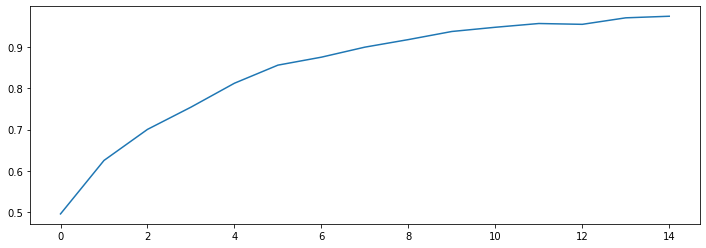

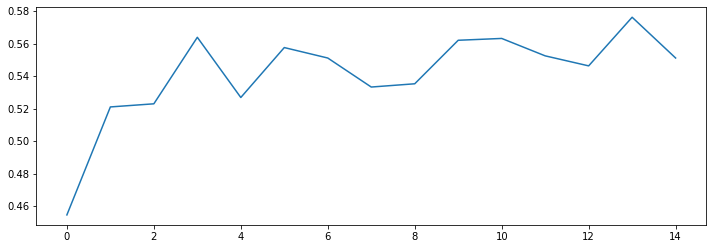

[[ 335   67  378]
 [ 122  177  323]
 [ 424  169 1851]]
[[ 442   51  287]
 [  75  199  348]
 [ 133   82 2229]]
[[ 542   40  198]
 [  72  251  299]
 [ 100   80 2264]]
[[ 588   38  154]
 [  52  315  255]
 [  84   86 2274]]
[[ 639   33  108]
 [  41  379  202]
 [  66   69 2309]]
[[ 684   32   64]
 [  46  435  141]
 [  59   55 2330]]
[[ 676   25   79]
 [  32  482  108]
 [  39   74 2331]]
[[ 707   18   55]
 [  31  517   74]
 [  51   63 2330]]
[[ 720   19   41]
 [  21  521   80]
 [  32   41 2371]]
[[ 731   13   36]
 [  15  548   59]
 [  33   26 2385]]
[[ 737    7   36]
 [   9  572   41]
 [  29   36 2379]]
[[ 751    7   22]
 [  16  570   36]
 [  15   27 2402]]
[[ 747   11   22]
 [   8  576   38]
 [  26   28 2390]]
[[ 759    4   17]
 [   5  584   33]
 [  12   16 2416]]
[[ 766    4   10]
 [   4  595   23]
 [  15   20 2409]]
[[ 66  10 210]
 [  5  25 157]
 [ 22  11 804]]
[[119  29 138]
 [ 11  38 138]
 [ 59  36 742]]
[[112  26 148]
 [  9  34 144]
 [ 30  33 774]]
[[144  49  93]
 [ 15  68 104]
 [ 67  

In [6]:
# show the trend-line of prediction F1 score for training and test set
def plot_f1_over_time(epoch_0_dataframe, all_probs):
    # epoch_0_dataframe is the dataframe results at epoch 0
    # probs_progression is the list of probabilities for each epoch
    gt = np.array(epoch_0_dataframe['y'])
    preds = [np.argmax(p, axis=1) for p in all_probs]
    f1s = [f1_score(gt, p, average='macro') for p in preds]
    fig, ax = plt.subplots(figsize=(12,4))
    t = np.arange(len(preds))
    ax.plot(t, f1s)
    plt.show()

def cf_over_time(epoch_0_dataframe, all_probs):
    gt = np.array(epoch_0_dataframe['y'])
    preds = [np.argmax(p, axis=1) for p in all_probs]
    [print(confusion_matrix(gt, p)) for p in preds]

plot_f1_over_time(train_df[0], train_probs)
plot_f1_over_time(val_df[0], val_probs)
cf_over_time(train_df[0], train_probs)
cf_over_time(val_df[0], val_probs)

Epoch 0, F1 score = 0.45455801594975975


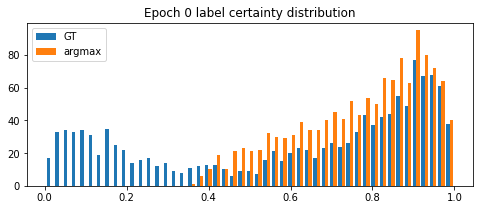

Epoch 1, F1 score = 0.5210405323653963


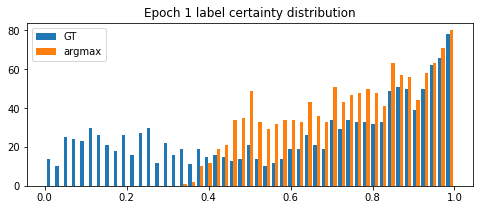

Epoch 2, F1 score = 0.5229651329081232


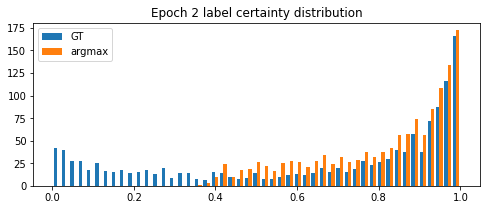

Epoch 3, F1 score = 0.5639090554254489


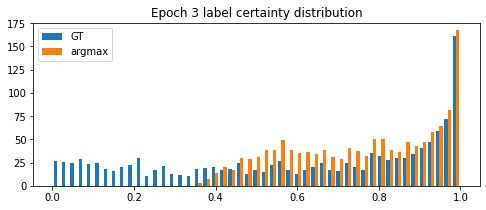

Epoch 4, F1 score = 0.5268530747339804


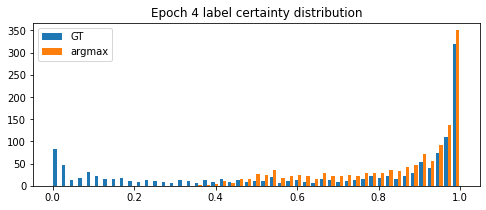

Epoch 5, F1 score = 0.5575934001750902


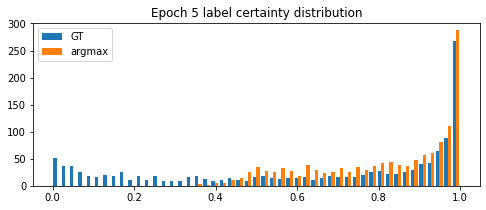

Epoch 6, F1 score = 0.5511548254353767


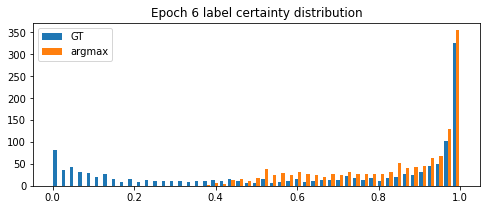

Epoch 7, F1 score = 0.5332923277152694


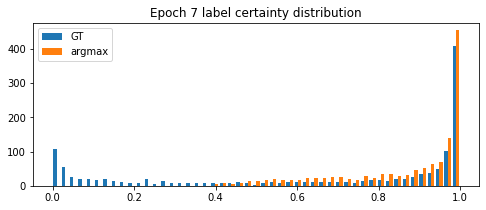

Epoch 8, F1 score = 0.5352952858294917


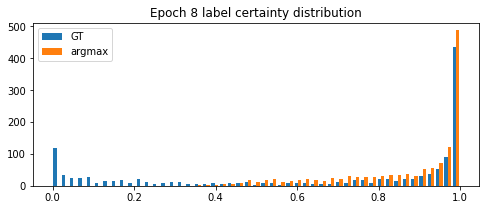

Epoch 9, F1 score = 0.5620865345892295


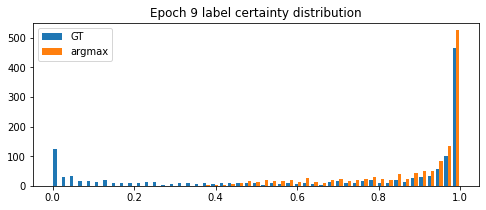

Epoch 10, F1 score = 0.5632133027055131


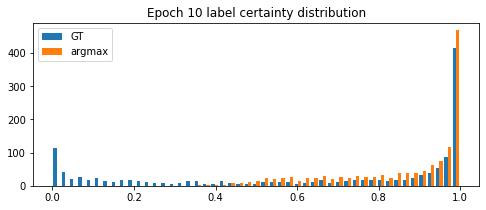

Epoch 11, F1 score = 0.5524931909998845


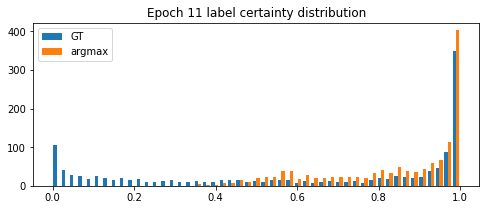

Epoch 12, F1 score = 0.5463214191517828


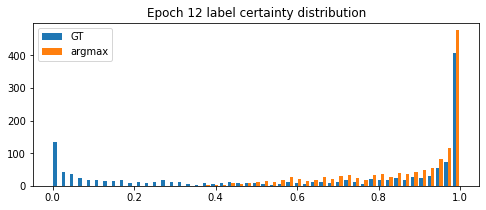

Epoch 13, F1 score = 0.5762633508688029


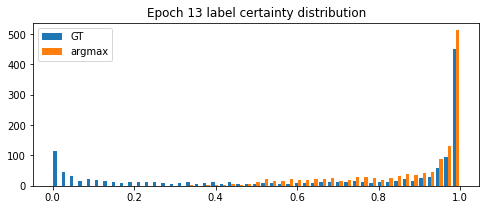

Epoch 14, F1 score = 0.5511646413131757


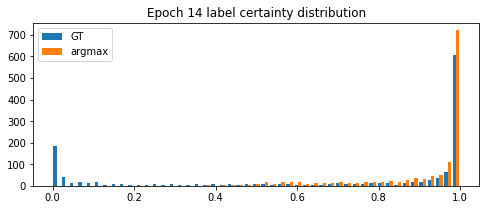

In [7]:
# we are setting up the validation set as the calibration set, to be more kosher, you should use an unseen subset of training
# check the certainty distribution of validation set
def certainty_hist(y, preds, epoch=-1):
    # y is (N,) integer array of C classes
    # preds is (N, C) array
    pred_classes = np.argmax(preds,axis=1)
    pred_confidence = np.max(preds,axis=1)
    gt_confidence = preds[range(len(y)),y]
    print(f"Epoch {epoch}, F1 score = {f1_score(y, pred_classes, average='macro')}")
    fig, ax = plt.subplots(figsize=(8,3))
    ax.hist([gt_confidence, pred_confidence], bins=49)
    plt.legend(['GT', 'argmax'])
    plt.title(f"Epoch {i} label certainty distribution")
    plt.show()

# first check the validation set for naive softmaxing
for i in range(len(val_df)):
    y = val_df[i]['y']
    preds = softmax(val_probs[i], axis=1)
    certainty_hist(y, preds, i)

In [8]:
# run conformal prediction on a select epoch to return the prediction sets
def RAPS(y, preds, desired_accuracy=0.9):
    # y is (N,) integer array of C classes
    # preds is (N, C) array of confidences
    # desired_accuracy is equivalent to 1-alpha in CP literature
    N = len(y)
    pred_classes = np.argmax(preds,axis=1)
    pred_confidence = np.max(preds,axis=1)
    gt_confidence = preds[range(N),y]
    # calculate the conformal score s as a general imprecise uncertainty measure (can be many ways, this is a simple way)
    s = 1 - gt_confidence
    # find the q level
    q_level = np.quantile(s, desired_accuracy)
    adj_q_level = np.ceil((N+1) * desired_accuracy)/N
    # create sets based on the q-level
    cutoff = 1 - adj_q_level
    conformal_set = []
    for i in range(N):
        conformal_set.append(preds[i] >= cutoff)
    return np.array(conformal_set)

y = val_df[2]['y']
preds = softmax(val_probs[2], axis=1)
cs = RAPS(y, preds, ALPHA)

In [9]:
# test the coverage of conformal prediction
def coverage_test(y, preds_cover):
    # y is (N,) integer array of C classes
    # preds_cover is (N, C) boolean array indicating the cover
    correct = []
    for i in range(len(y)):
        if preds_cover[i, y[i]]:
            correct.append(True)
        else:
            correct.append(False)
    return np.array(correct)

correctness = coverage_test(y, cs) 
print(np.sum(correctness)/len(y)) # should be around 0.9

0.8862595419847328


In [10]:
def class_conditional_coverage_test(y, preds_cover, num_classes=4):
    # returns an accuracy for each class
    class_cond_acc = np.zeros(num_classes)
    for c in range(num_classes):
        mask = y == c
        preds_c = preds_cover[mask]
        N_c = len(preds_c)
        correct = 0
        for i in range(N_c):
            if preds_c[i,c]:
                correct += 1
        class_cond_acc[c] = correct/N_c
    return class_cond_acc
correctness = class_conditional_coverage_test(y, cs, N_CLASSES) 
correctness

array([0.73076923, 0.62566845, 0.99761051])

In [11]:
# check the cardinality of the conformal prediction
def cp_cardinality(y, preds_cover, preds, n_classes=4):
    cardinality = np.sum(preds_cover, axis=1)
    correct = coverage_test(y, preds_cover)
    card_correct = cardinality[correct]
    card_incorrect = cardinality[~correct]
    
    n_bins = n_classes + 1
    c_amount, c_bins = np.histogram(card_correct, bins=np.arange(n_bins)+0.5)
    n_amount, _ = np.histogram(card_incorrect, bins=np.arange(n_bins)+0.5)
    card_acc = c_amount / (c_amount + n_amount + 1e-9)
    print(f"Number of correct preds of size [1..N_classes]: {c_amount}")
    print(f"Number of incorrect preds of size [1..N_classes]: {n_amount}")
    print(f"Accuracy of preds of size [1..N_classes]: {card_acc}")

    top1_accs = []
    pred_classes = np.argmax(preds, axis=1)
    for i in np.arange(n_classes)+1:
        gt_w_card_i = y[cardinality==i]
        pred_w_card_i = pred_classes[cardinality==i]
        acc_w_card_i = np.sum(gt_w_card_i == pred_w_card_i) / (len(gt_w_card_i) + 1e-9)
        top1_accs.append(acc_w_card_i)
    print(f"Top-1 acc of preds of size [1..N_classes]: {top1_accs}")
    return np.mean(cardinality)

cp_cardinality(y, cs, preds, n_classes=N_CLASSES)

Number of correct preds of size [1..N_classes]: [555 385 221]
Number of incorrect preds of size [1..N_classes]: [98 51  0]
Accuracy of preds of size [1..N_classes]: [0.84992343 0.88302752 1.        ]
Top-1 acc of preds of size [1..N_classes]: [0.849923430320291, 0.6055045871545746, 0.45701357465856557]


1.6702290076335877

In [12]:
# run conformal prediction on each epoch
f1s = []
coverages = []
cardinalities = []
for i in range(len(val_df)):
    y = np.array(val_df[i]['y'])
    preds = softmax(val_probs[i], axis=1)
    pred_classes = np.argmax(preds,axis=1)
    print(f"Epoch {i}")
    print(f"Original classifier F1 = {f1_score(y, pred_classes, average='macro')}")
    f1s.append(f1_score(y, pred_classes, average='macro'))
    cs = RAPS(y, preds, ALPHA)
    correctness = coverage_test(y, cs)
    print(f"Conformal coverage accuracy = {np.sum(correctness)/len(y)}")
    coverages.append(np.sum(correctness)/len(y))
    correctness = class_conditional_coverage_test(y, cs, num_classes=N_CLASSES)
    print(f"Class-conditional coverage accuracy = {correctness}")
    avg_card = cp_cardinality(y, cs, preds, n_classes=N_CLASSES)
    cardinalities.append(avg_card)

Epoch 0
Original classifier F1 = 0.45455801594975975
Conformal coverage accuracy = 0.8938931297709923
Class-conditional coverage accuracy = [0.73076923 0.6684492  1.        ]
Number of correct preds of size [1..N_classes]: [420 411 340]
Number of incorrect preds of size [1..N_classes]: [85 54  0]
Accuracy of preds of size [1..N_classes]: [0.83168317 0.88387097 1.        ]
Top-1 acc of preds of size [1..N_classes]: [0.8316831683151849, 0.664516129030829, 0.4882352941162111]
Epoch 1
Original classifier F1 = 0.5210405323653963
Conformal coverage accuracy = 0.9320610687022901
Class-conditional coverage accuracy = [0.83566434 0.81818182 0.99044205]
Number of correct preds of size [1..N_classes]: [394 416 411]
Number of incorrect preds of size [1..N_classes]: [39 50  0]
Accuracy of preds of size [1..N_classes]: [0.90993072 0.89270386 1.        ]
Top-1 acc of preds of size [1..N_classes]: [0.9099307159332335, 0.6974248927023661, 0.43795620437849647]
Epoch 2
Original classifier F1 = 0.52296513

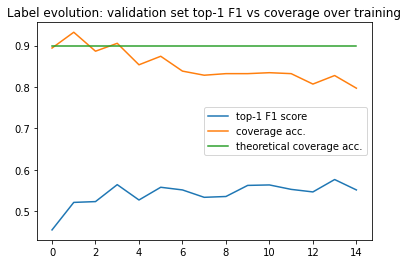

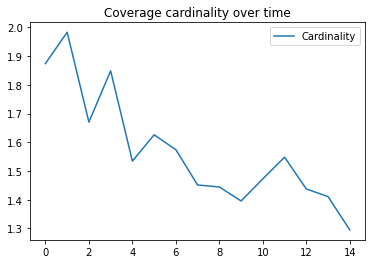

In [13]:
plt.plot(range(len(val_df)), f1s)
plt.plot(range(len(val_df)), coverages)
plt.plot(range(len(val_df)), np.full(shape=len(val_df), fill_value=ALPHA))
plt.title('Label evolution: validation set top-1 F1 vs coverage over training')
plt.legend(['top-1 F1 score', 'coverage acc.', 'theoretical coverage acc.'])
plt.show()

plt.figure()
plt.plot(range(len(val_df)), cardinalities)
plt.title('Coverage cardinality over time')
plt.legend(['Cardinality'])
plt.show()